# Logistic Regression
> y1, y2
* train 데이터셋을 보고 y1 y2값이 0과 1로만 구성되어있는 것을 보고 분류 문제로 판단
* 따라서 sigmoid(z)를 함수로 두고 경사하강법으로 최적화 해나감
* Cross entropy loss를 이용해 loss값 계산

$ −[y⋅log(p)+(1−y)⋅log(1−p)] $


# Gradient Descent linear regression
> y3
* 데이터가 연속적인 수치라서 선형회귀가 적합하다고 판단
* 경사하강법을 통해 y=Xw+b 최적화
* MSE를 loss로 사용하는 선형회귀


# Soft k-means
> y4
* 비지도학습으로 보고 클러스터링 알고리즘이 적합하다고 판단
* Soft KMeans는 각 점이 여러 군집에 속할 확률을 가질 수 있어 좀 더 유연한 결과가 도출되므로 적합하다고 판단
* 초기 중심을 무작위로 잡고 각 샘플에 대해 R 계산
* beta 값을 이용해 유사도를 부드럽게 반영
* 중심점을 반복적으로 이동시킴
* 각 점이 특정 중심에 속할 책임도 x 거리 제곱의 가중합을 손실함수로 두고 loss값 계산


## 학습 결과
* y1의 경우 Loss가 꾸준히 감소하고, 기울기도 완만해지고 있어 수렴되는 것을 확인
* y2 역시 y1보다 더 빠르게 수렴하고 안정적임
* y3의 경우 거의 0 근처까지 수렴하고 있어 선형 회귀가 잘 되고 있음을 확인
* y4의 경우 중심들이 처음에 크게 이동하다가 점점 작아지는 것을 보고 수렴중인 것을 확인

y1 클래스 분포:
0    12194
1     3806
Name: y1, dtype: int64

y2 클래스 분포:
0    8625
1    7375
Name: y2, dtype: int64


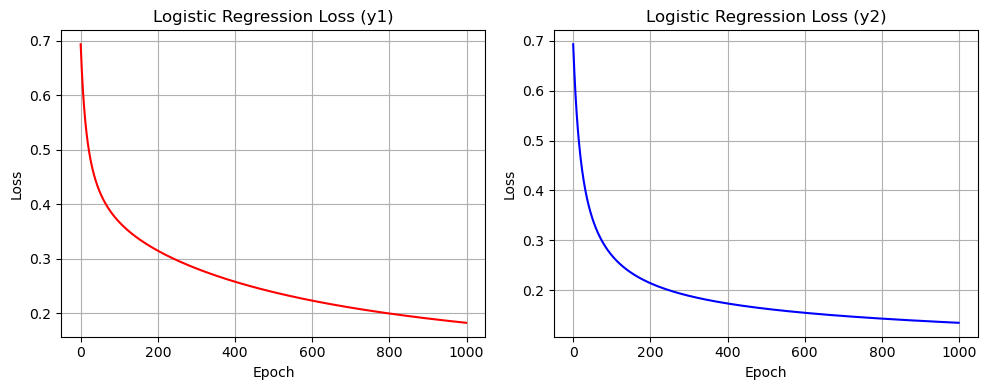

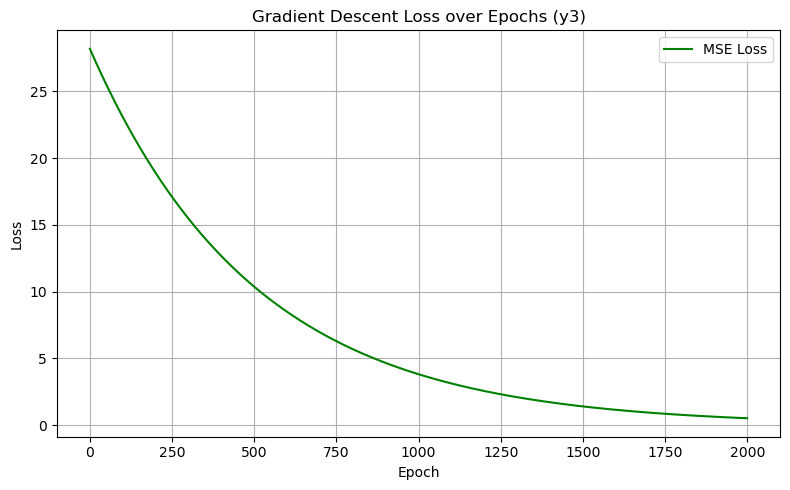

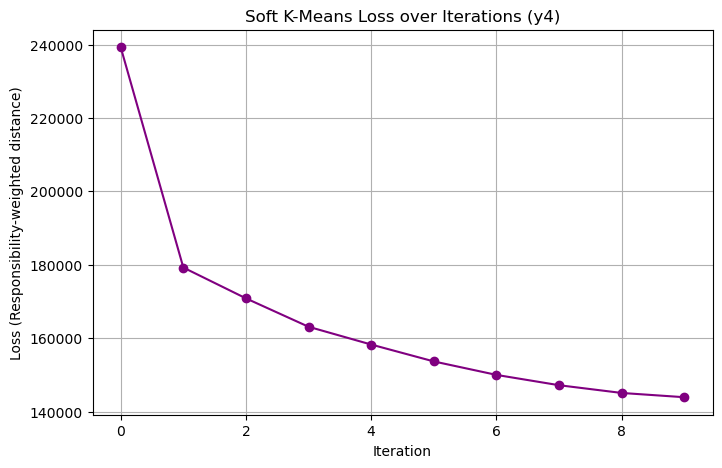

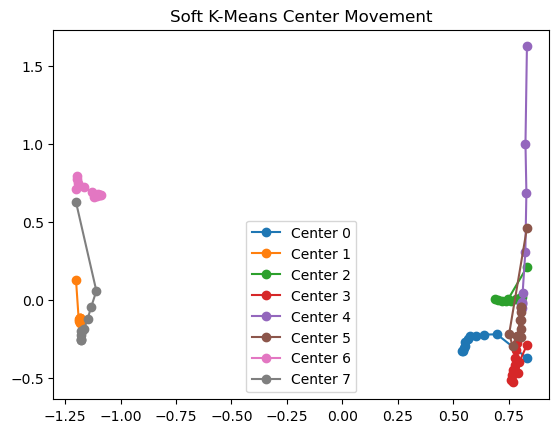

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
df_train = pd.read_excel("data/세종시_인바디_데이터셋.xlsx")
df_submit = pd.read_excel("data/세종시_인바디_제출용(이유정).xlsx")

print("y1 클래스 분포:")
print(df_train['y1'].value_counts().sort_index())

print("\ny2 클래스 분포:")
print(df_train['y2'].value_counts().sort_index())

# 2. Feature & Target 분리
X = df_train.iloc[:, :33].values
y1 = df_train['y1'].values
y2 = df_train['y2'].values
y3 = df_train['y3'].values
y4 = df_train['y4'].values
X_submit = df_submit.iloc[:, :33].values

# 3. 표준화 함수
def standardize(X, mean=None, std=None):
    if mean is None or std is None:
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
    return (X - mean) / std, mean, std

X_scaled, mean_X, std_X = standardize(X)
X_submit_scaled, _, _ = standardize(X_submit, mean_X, std_X)

# 4. 로지스틱 회귀
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def gradient_descent_logistic(X, y, lr=0.01, epochs=1000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = 0
    loss_history = []

    for _ in range(epochs):
        linear = X @ w + b
        y_pred = sigmoid(linear)
        
        loss = -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))
        loss_history.append(loss)

        dw = (1 / n_samples) * (X.T @ (y_pred - y))
        db = (1 / n_samples) * np.sum(y_pred - y)

        w -= lr * dw
        b -= lr * db

    return w, b, loss_history

def predict_logistic(X, w, b, threshold=0.5):
    return (sigmoid(X @ w + b) >= threshold).astype(int)

# 5. 선형 회귀
def gradient_descent(X, y, lr=0.01, epochs=1000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = 0
    loss_history = []

    for _ in range(epochs):
        y_pred = X @ w + b
        error = y_pred - y

        loss = (1 / (2 * n_samples)) * np.sum(error ** 2)
        loss_history.append(loss)

        w_grad = (1 / n_samples) * (X.T @ error)
        b_grad = (1 / n_samples) * np.sum(error)

        w -= lr * w_grad
        b -= lr * b_grad

    return w, b, loss_history

def linear_regression_predict(X, w, b):
    return X @ w + b

# 6. Soft K-Means
def soft_kmeans(X, n_centers, beta=1.0, iterations=10):
    n_samples, n_features = X.shape
    np.random.seed(42)
    indices = np.random.choice(n_samples, n_centers, replace=False)
    centers = X[indices]

    history = [centers.copy()]
    loss_history = []

    for _ in range(iterations):
        R = np.zeros((n_samples, n_centers))
        for i in range(n_centers):
            dist = np.sum((X - centers[i]) ** 2, axis=1)
            R[:, i] = np.exp(-beta * dist)

        row_sums = np.sum(R, axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        R /= row_sums

        loss = 0
        for i in range(n_centers):
            dist_sq = np.sum((X - centers[i]) ** 2, axis=1)
            loss += np.sum(R[:, i] * dist_sq)
        loss_history.append(loss)

        for i in range(n_centers):
            centers[i] = np.sum(R[:, i][:, np.newaxis] * X, axis=0) / np.sum(R[:, i])

        history.append(centers.copy())

    return centers, history, loss_history

def soft_kmeans_predict(X, centers, beta=1.0):
    dists = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
    weights = np.exp(-beta * dists)
    weights /= weights.sum(axis=1, keepdims=True)
    return np.argmax(weights, axis=1)

# 7. 모델 학습 및 예측
w_y1, b_y1, loss_y1 = gradient_descent_logistic(X_scaled, y1, lr=0.01, epochs=1000)
pred_y1 = predict_logistic(X_submit_scaled, w_y1, b_y1)

w_y2, b_y2, loss_y2 = gradient_descent_logistic(X_scaled, y2, lr=0.01, epochs=1000)
pred_y2 = predict_logistic(X_submit_scaled, w_y2, b_y2)

w_y3, b_y3, loss_y3 = gradient_descent(X_scaled, y3, lr=0.001, epochs=2000)
pred_y3 = linear_regression_predict(X_submit_scaled, w_y3, b_y3)

final_centers, center_history, loss_y4 = soft_kmeans(X_scaled, n_centers=8, beta=1.0, iterations=10)
pred_y4 = soft_kmeans_predict(X_submit_scaled, final_centers, beta=1.0)

# 8. 손실 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_y1, label='y1 Loss', color='red')
plt.title('Logistic Regression Loss (y1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss_y2, label='y2 Loss', color='blue')
plt.title('Logistic Regression Loss (y2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(loss_y3, label="MSE Loss", color='green')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Gradient Descent Loss over Epochs (y3)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(loss_y4, marker='o', color='purple')
plt.title("Soft K-Means Loss over Iterations (y4)")
plt.xlabel("Iteration")
plt.ylabel("Loss (Responsibility-weighted distance)")
plt.grid(True)
plt.show()

# 9. y4 중심 이동 시각화
for i in range(8):
    trace = np.array([c[i] for c in center_history])
    plt.plot(trace[:, 0], trace[:, 1], marker='o', label=f'Center {i}')
plt.title("Soft K-Means Center Movement")
plt.legend()
plt.show()

# 10. 결과 저장
df_submit['y1'] = pred_y1
df_submit['y2'] = pred_y2
df_submit['y3'] = pred_y3
df_submit['y4'] = pred_y4
df_submit.to_csv("세종시_인바디_제출용(이유정).csv", index=False)